In [26]:
import h5py
import pandas as pd
import numpy as np
import os


def parse_timestamp(ts):
    ts = str(ts)
    if len(ts) == 17:
        year = int(ts[0:4])
        month = int(ts[4:6])
        day = int(ts[6:8])
        hour = int(ts[8:10])
        minute = int(ts[10:12])
        second = int(ts[12:14])
        millisecond = int(ts[14:17])
        microsecond = millisecond * 1000

        return pd.Timestamp(year, month, day, hour, minute, second, microsecond)
    else:
        return pd.NaT
    
def vwap(df, level=10, _type="all"):
    if _type == "ask":
        pv = df.apply(lambda row: sum([row[f"AskPrice{str(i)}"]*row[f"AskVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
        v = df.apply(lambda row: sum([row[f"AskVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
    if _type == "bid":
        pv = df.apply(lambda row: sum([row[f"BidPrice{str(i)}"]*row[f"BidVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
        v = df.apply(lambda row: sum([row[f"BidVolume{str(i)}"] for i in range(1,level+1)]),axis=1)
    if _type == "all":
        askvwap, askv = vwap(df, level, _type="ask")
        bidvwap, bidv = vwap(df, level, _type="bid")
        pv, v = askvwap*askv + bidvwap*bidv, askv + bidv
    return pv/v, v

class PPL:
    def __init__(self, base_path="./interview"):
        self.base_path = base_path

    def profiler(self, dayprofiler, kwargs={}, id="002521", start_date="20220601", end_date="20221013"):
        dates = list(map(lambda x: x.strftime("%Y%m%d"), pd.date_range(start=start_date, end=end_date).tolist()))
        res = []
        res_dates = []
        for date in dates:
            if os.path.exists(f'{self.base_path}/{id}_{date}.h5'):
                res_dates.append(date)
                with h5py.File(f'{self.base_path}/{id}_{date}.h5', 'r') as f:
                    res.append(dayprofiler(f, **kwargs))
        return pd.concat(res, keys=res_dates, names=["Date"])
    
    @staticmethod
    def get_basic(f, freq="1min"):
        df = pd.DataFrame({
            k: f[k][:] for k in f.keys()
        })
        df["MidPrice"] = (df["AskPrice1"] * df["AskVolume1"] + df["BidPrice1"] * df["BidVolume1"]) / (df["AskVolume1"] + df["BidVolume1"])
        df["Time"] = df["DataTime"].apply(parse_timestamp)
        df.set_index("Time", inplace=True)
        resampled = df.resample(freq).agg(
            {
                "MidPrice" : ["first", "last"],
                "Volume" : ["first", "last"],
            }
        )
        res = pd.DataFrame({
            "open" : resampled["MidPrice"]["first"],
            "close" : resampled["MidPrice"]["last"],
            "volume": resampled["Volume"]["last"] - resampled["Volume"]["first"] 
        })
        res["Time"] = res.index.strftime("%H%M%S")
        res = res.set_index("Time").dropna(how="all")
        res.iloc[0]["volume"] = resampled["Volume"]["last"].iloc[0]
        return res
    
    @staticmethod
    def get_close(f):
        df = pd.DataFrame({
            k: f[k][:] for k in f.keys()
        })
        df["MidPrice"] = (df["AskPrice1"] * df["AskVolume1"] + df["BidPrice1"] * df["BidVolume1"]) / (df["AskVolume1"] + df["BidVolume1"])
        
        return pd.DataFrame({
            "close": np.array([df["MidPrice"].iloc[-1]])
        })
    
    

In [27]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)

In [148]:
ppl = PPL()
df = ppl.profiler(PPL.get_basic, kwargs={"freq":"30min"})

In [149]:
df["return"] = (df["close"] - df["open"])/df["open"]

In [150]:
close = ppl.profiler(PPL.get_close).reset_index(level=1, drop=True)

In [151]:
df["preclose"] = df.index.get_level_values(0).map(close["close"].shift(1))

In [152]:
df["ovnreturn"] = df.index.get_level_values(0).map(df.xs("093000", level="Time").apply(lambda row: row["open"]/row["preclose"] - 1, axis=1))

In [153]:
df["ovnreturn"] = df["ovnreturn"].fillna(0)

In [154]:
df.xs("093000",level="Time")["return"].corr(df.xs("093000",level="Time")["ovnreturn"])

-0.2168473557141366

In [155]:
df.groupby(level="Time").apply(lambda group: group["return"].corr(group["ovnreturn"]))

Time
093000   -0.216847
100000   -0.092976
103000    0.114221
110000   -0.099481
130000   -0.007493
133000   -0.116916
140000    0.153314
143000    0.110204
dtype: float64

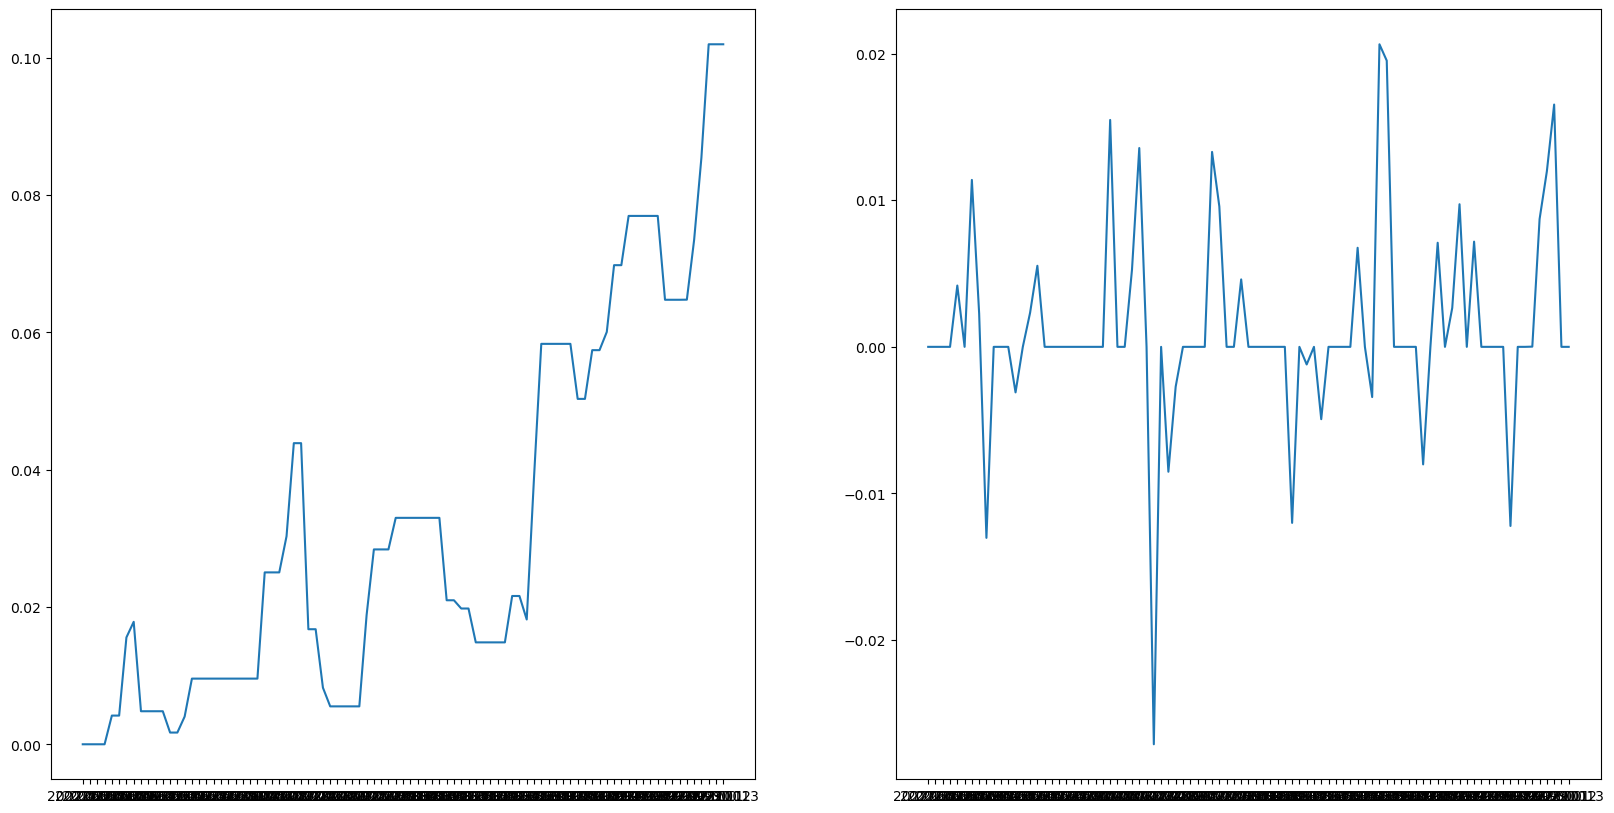

In [177]:
def inversetrading(row, tc = 0.0004):
    row["delay_return"] = row["return"].shift(-1).fillna(0)
    return (row[row["return"] < -0.002]["delay_return"] - tc).sum() + (-row[row["return"] > 0.002]["delay_return"] - tc).sum()

def ovninversetrading(row, tc=0.0014):
    if row["ovnreturn"].iloc[0] > 0.005:
        return -row["return"].iloc[0] - tc
    if row["ovnreturn"].iloc[0] < -0.005:
        return row["return"].iloc[0] - tc
    return 0

rtn = df.groupby(level="Date").apply(ovninversetrading)

import matplotlib.pyplot as plt
_,axes = plt.subplots(1,2,figsize=(20,10))
axes[0].plot(rtn.cumsum())
axes[1].plot(rtn)

In [174]:
df.xs("093000",level="Time")["ovnreturn"].std()

0.006309184175418411

In [162]:
rtn

Date
20220601    0.000000
20220602    0.000000
20220606    0.000000
20220607    0.000000
20220608    0.004180
20220609    0.000000
20220610    0.011383
20220613    0.002275
20220614   -0.013025
20220615    0.000000
20220616    0.000000
20220617    0.000000
20220620   -0.003105
20220621    0.000000
20220622    0.002329
20220623    0.005528
20220624    0.000000
20220627    0.000000
20220628    0.000000
20220629    0.000000
20220630    0.000000
20220701    0.000000
20220704    0.000000
20220705    0.000000
20220706    0.000000
20220707    0.015472
20220708    0.000000
20220711    0.000000
20220712    0.005266
20220713    0.013557
20220714    0.000000
20220715   -0.027101
20220718    0.000000
20220719   -0.008516
20220720   -0.002720
20220721    0.000000
20220722    0.000000
20220725    0.000000
20220726    0.000000
20220727    0.013292
20220728    0.009570
20220729    0.000000
20220801    0.000000
20220803    0.004598
20220804    0.000000
20220805    0.000000
20220808    0.000000
20220809

In [76]:
import matplotlib.pyplot as plt

def plotfigs(date = "20220601"):

    _, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

    axes[0].plot(df.xs(date, level="Date")["volume"])
    axes[0].set_title("Volume")

    axes[1].plot(df.xs(date, level="Date")["open"])
    axes[1].set_title("Price")

    axes[2].plot(df.xs(date, level="Date")["return"])
    axes[2].set_title("Return")
    plt.show()


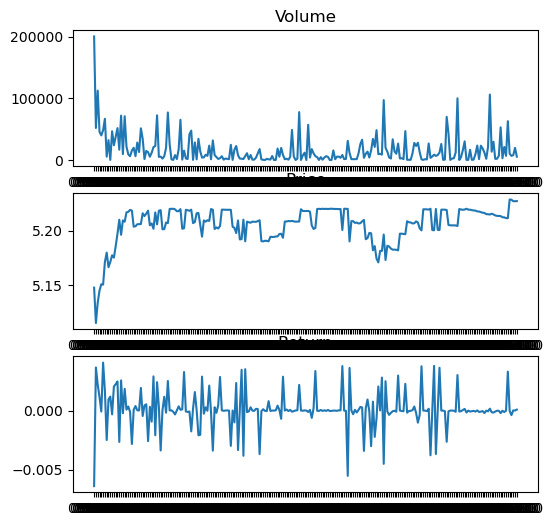

In [77]:
plotfigs("20220601")

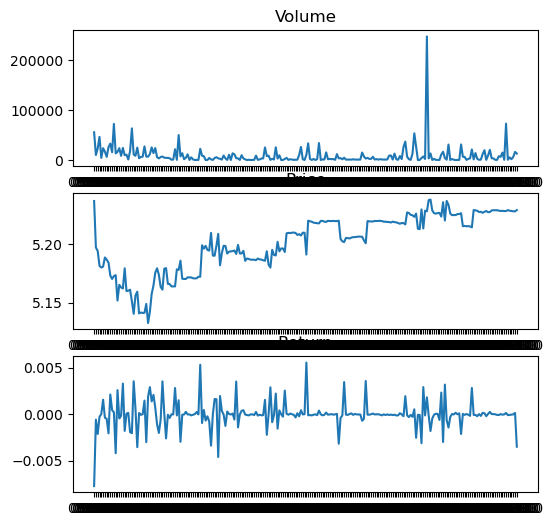

In [78]:
plotfigs("20220602")

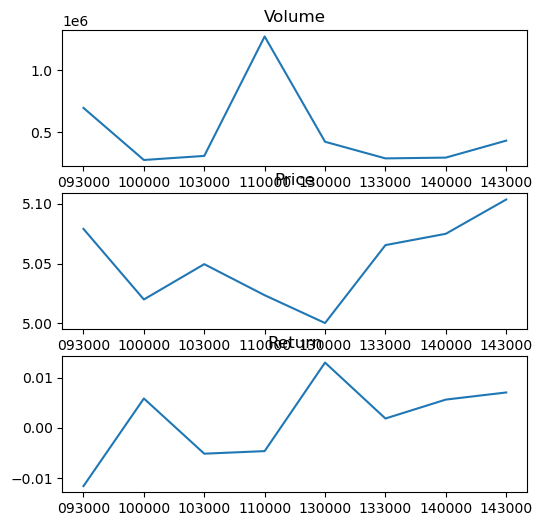

In [163]:
plotfigs("20220614")

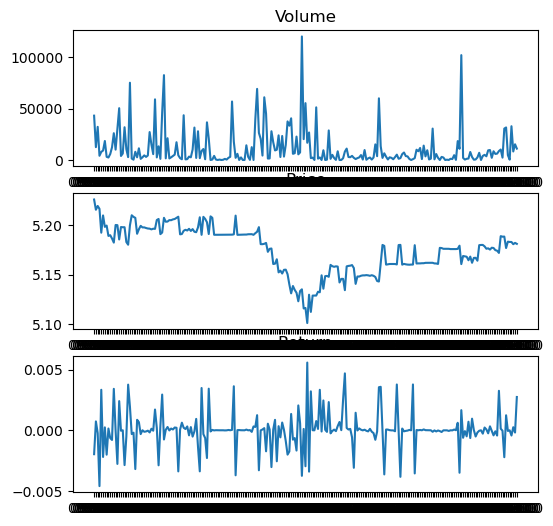

In [80]:
plotfigs("20220608")